In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as show

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
import keras
from keras import Model, models, layers, metrics
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [4]:
import os

In [5]:
from sklearn.utils import shuffle
from sklearn import metrics

In [6]:
from keras.utils import to_categorical

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
#histogram Equalisation for image preprocessing
def hist(img): 
  img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalisation_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalisation_result

In [9]:
#Bilateral Filter for the image
def BilateralFilter(img):
  return cv2.bilateralFilter(img,5,75,75)

In [10]:
def imgPreprocessing(img):
  img = hist(img)
  img = BilateralFilter(img)
  return img

In [7]:
#loading images function 
#path - location of directory with images
#img_list - list of names of files within path directory 
#label - numeric value of the particular status 0 - normal, 1 - pneumonia, 2 - covid19
def loadImages(path, img_names_list, label):
  images = []
  labels = []
  
  for i in range(len(img_names_list)):
    if (i == 460): break
    img_path = path + "/" + img_names_list[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512,512)) #making sure all images are the same same for neural network
    img = imgPreprocessing(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  #Normalisation
    images.append(img)
    labels.append(label)

  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

In [11]:
class_names = ['Normal', 'Pneumonia', 'Covid-19']
class_hints = [None] * 3
class_hints[0] = 'No abnormalities detected'
class_hints[1] = "Is there any single lobe or segment opacification?\n" + \
                  "Are these opacifications maybe multifocal in various locations?\n" + \
                  "Are other areas of lung visualised as having normal air exchange (no opacification)?"
class_hints[2] = "Is image ground-grass opacity?\n" + \
                 "Are consolidations peripheral? \n" + \
                 "Are consolidations bilateral?"

In [30]:
#----------------------------------------LOADING TRAINING DATA--------------------------------------------------------
covid_train_path = '/content/drive/MyDrive/ComputerScienceProject/archive/train/COVID19'
covid_img_nameslist = os.listdir(covid_train_path)
covid_img, covid_labels = loadImages(covid_train_path, covid_img_nameslist, 2)

In [31]:
normal_train_path = '/content/drive/MyDrive/ComputerScienceProject/archive/train/NORMAL'
normal_img_nameslist = os.listdir(normal_train_path)
normal_img, normal_labels = loadImages(normal_train_path, normal_img_nameslist, 0)

In [32]:
pneumonia_train_path = '/content/drive/MyDrive/ComputerScienceProject/archive/train/PNEUMONIA'
pneumonia_img_nameslist = os.listdir(pneumonia_train_path)
pneumonia_img, pneumonia_labels = loadImages(pneumonia_train_path, pneumonia_img_nameslist, 1)

In [33]:
training_data = np.r_[normal_img, covid_img, pneumonia_img]
labels = np.r_[normal_labels, covid_labels, pneumonia_labels]

In [34]:
training_data_shuffled, labels_shuffled = shuffle(training_data, labels, random_state = 0)

In [35]:
training_data_shuffled = training_data_shuffled.reshape(1380, 512, 512, 1)
training_data_shuffled.shape

(1380, 512, 512, 1)

In [36]:
labels_amended_shuffled = to_categorical(labels_shuffled)
labels_amended_shuffled.shape

(1380, 3)

In [37]:
#-------------------------------------------LOADING TEST DATA-------------------------------------------------
covid_test_path = '/content/drive/MyDrive/ComputerScienceProject/archive/test/COVID19'
covid_test_nameslist = os.listdir(covid_test_path)
covid_test_img, covid_test_labels = loadImages(covid_test_path, covid_test_nameslist, 2)

In [38]:
normal_test_path = '/content/drive/MyDrive/ComputerScienceProject/archive/test/NORMAL'
normal_test_nameslist = os.listdir(normal_test_path)
normal_test_img, normal_test_labels = loadImages(normal_test_path, normal_test_nameslist, 0)

In [39]:
pneumonia_test_path = '/content/drive/MyDrive/ComputerScienceProject/archive/test/PNEUMONIA'
pneumonia_test_nameslist = os.listdir(pneumonia_test_path)
pneumonia_test_img, pneumonia_test_labels = loadImages(pneumonia_test_path, pneumonia_test_nameslist, 1)

In [40]:
test_data = np.r_[normal_test_img, covid_test_img, pneumonia_test_img]
test_labels = np.r_[normal_test_labels, covid_test_labels,pneumonia_test_labels,]

In [41]:
test_data = test_data.reshape(730, 512, 512, 1)
test_data.shape

(730, 512, 512, 1)

In [42]:
test_labels_amended = to_categorical(test_labels)
test_labels_amended.shape

(730, 3)

In [15]:
#-------------------------------------------LOADING VALIDATION DATA---------------------------------------------------
normal_val_path = '/content/drive/MyDrive/ComputerScienceProject/archive/val/NORMAL'
normal_val_nameslist = os.listdir(normal_val_path)
normal_val_img, normal_val_labels = loadImages(normal_val_path, normal_val_nameslist, 0)

In [16]:
covid_val_path = '/content/drive/MyDrive/ComputerScienceProject/archive/val/COVID19'
covid_val_nameslist = os.listdir(covid_val_path)
covid_val_img, covid_val_labels = loadImages(covid_val_path, covid_val_nameslist, 2)

In [17]:
pneumonia_val_path = '/content/drive/MyDrive/ComputerScienceProject/archive/val/PNEUMONIA'
pneumonia_val_nameslist = os.listdir(pneumonia_val_path)
pneumonia_val_img, pneumonia_val_labels = loadImages(pneumonia_val_path, pneumonia_val_nameslist, 1)

In [18]:
val_data = np.r_[covid_val_img, pneumonia_val_img, normal_val_img]
val_labels = np.r_[covid_val_labels, pneumonia_val_labels, normal_val_labels]

In [19]:
val_data= val_data.reshape(26, 512, 512, 1)
val_data.shape

(26, 512, 512, 1)

In [20]:
val_labels_amended = to_categorical(val_labels)
val_labels_amended.shape

(26, 3)

In [53]:
#---------------------------------------CNN ALEXNET MODEL IMPLEMENTATION----------------------------------------------
AlexNet_model = Sequential()
AlexNet_model.add(Conv2D(96, 11, strides = 4, activation = 'relu', input_shape=(512, 512, 1), padding = 'valid'))
AlexNet_model.add(BatchNormalization())
AlexNet_model.add(MaxPool2D(3, strides = 2, padding = 'valid'))

AlexNet_model.add(Conv2D(256, 5, strides = 1, activation = 'relu', padding = 'same'))
AlexNet_model.add(MaxPool2D(3, strides = 2, padding = 'valid'))
AlexNet_model.add(BatchNormalization())

AlexNet_model.add(Conv2D(384, 3, strides = 1, activation = 'relu', padding = 'same'))
AlexNet_model.add(Conv2D(384, 3, strides = 1, activation = 'relu', padding = 'same'))
AlexNet_model.add(Conv2D(256, 3, strides = 1, activation = 'relu', padding = 'same'))

AlexNet_model.add(MaxPool2D(3, strides = 2))
AlexNet_model.add(Dropout(0.5))
AlexNet_model.add(BatchNormalization())

AlexNet_model.add(Flatten())
AlexNet_model.add(Dense(4096, activation = 'relu'))
AlexNet_model.add(BatchNormalization())
AlexNet_model.add(Dropout(0.3))
AlexNet_model.add(Dense(3, activation = 'softmax'))

In [55]:
AlexNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 96)      11712     
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                        

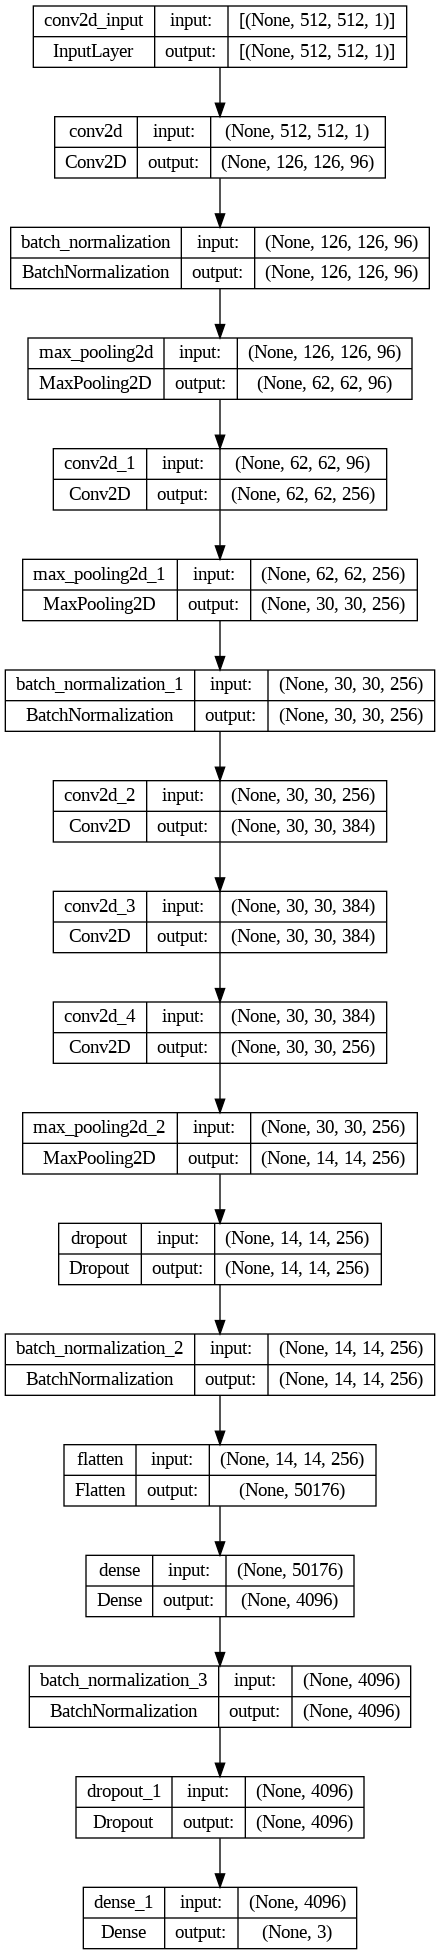

In [66]:
from keras.utils import plot_model
plot_model(AlexNet_model, show_shapes = True)

In [ ]:
AlexNet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
trained_model = AlexNet_model.fit(training_data_shuffled, labels_amended_shuffled, batch_size = 32, epochs = 20, validation_data=(test_data, test_labels_amended))

In [ ]:
predict = AlexNet_model.predict(val_data, batch_size=1, verbose = 1)
answer = np.argmax(predict, axis=1) #or answer = to_categorical(predict)
print(answer)

In [ ]:
print(val_labels)

In [22]:
#-------------------------------------------SAVING THE MODEL---------------------------------------------------
from keras.models import model_from_json

In [61]:
model_json = AlexNet_model.to_json()

In [ ]:
with open("AlexNet_model.json", 'w') as json_file:
  json_file.write(model_json)

AlexNet_model.save_weights("AlexNet_model_weights.h5")
print("Model saved to the disk")

In [23]:
json_file = open("/content/drive/MyDrive/ComputerScienceProject/AlexNet_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/MyDrive/ComputerScienceProject/AlexNet_model_weights.h5")
print("Model loaded")

Model loaded


In [24]:
loaded_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
loaded_model_predict = loaded_model.predict(val_data, batch_size=1, verbose = 1)
loaded_model_answer = np.argmax(loaded_model_predict, axis=1) #or answer = to_categorical(predict)
print(loaded_model_answer)

26/26 [==============================] - 3s 95ms/step
[2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 1 2 1 0 0 0 1 0 0 0 0]


In [28]:
print(val_labels)

[2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


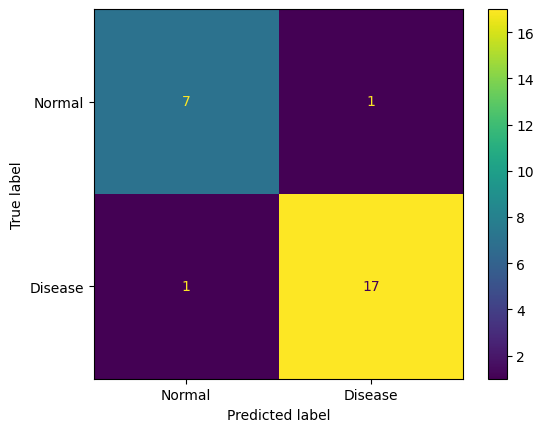

In [29]:
binary_val_labels = []
binary_prediction = []

for i in range(len(val_labels)):  # 0 = Normal 1 = Disease
  if (val_labels[i] == 1 or val_labels[i] == 2) :
    binary_val_labels.append(1)
  else:
    binary_val_labels.append(0)

for i in range(len(loaded_model_answer)):
  if (loaded_model_answer[i] == 1 or loaded_model_answer[i] == 2) :
    binary_prediction.append(1)
  else:
    binary_prediction.append(0)

actual = binary_val_labels
predicted = binary_prediction

confusion_matrix = metrics.confusion_matrix(actual, predicted)

ConfusionMatrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Normal', 'Disease'])

ConfusionMatrix_display.plot()
plt.show()
